In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization)
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [3]:
# Rutas de los conjuntos de datos
train_dir = '../data/train'
valid_dir = '../data/valid'
test_dir = '../data/test'

# Parámetros
img_height, img_width = 244, 244 
batch_size = 32

# Aumento de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Sólo reescalar para validación y prueba
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Para evaluar correctamente
)


Found 655 images belonging to 4 classes.
Found 92 images belonging to 4 classes.
Found 190 images belonging to 4 classes.


In [4]:
base_model_inception = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [5]:
# Congelar las capas del modelo base para no entrenarlas de nuevo
base_model_inception.trainable = False

# Aplanar las características extraídas por VGG16
x = Flatten()(base_model_inception.output)

# Agregar una capa completamente conectada con 512 unidades y activación ReLU
x = Dense(512, activation='relu')(x)

# Agregar Dropout para prevenir sobreajuste (ajuste fino del dropout según lo necesites)
x = Dropout(0.5)(x)

# Agregar la capa de salida con tantas unidades como clases en tu dataset
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model_inception.input, outputs=output)

# Compilar el modelo (puedes ajustar el optimizador o la tasa de aprendizaje según sea necesario)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con tus datos
history = model.fit(train_generator, 
                    validation_data=valid_generator, 
                    epochs=20, 
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_steps = valid_generator.samples // batch_size,
                    verbose=1)


c:\Users\emman\OneDrive\Escritorio\Proyecto Copia\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 6/20 ━━━━━━━━━━━━━━━━━━━━ 1:33 7s/step - accuracy: 0.2618 - loss: 4.6550

c:\Users\emman\OneDrive\Escritorio\Proyecto Copia\venv\lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
c:\Users\emman\OneDrive\Escritorio\Proyecto Copia\venv\lib\site-packages\PIL\JpegImagePlugin.py:846: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - accuracy: 0.3940 - loss: 3.6864 - val_accuracy: 0.7188 - val_loss: 0.7015
Epoch 2/20
 1/20 ━━━━━━━━━━━━━━━━━━━━ 2:13 7s/step - accuracy: 0.5938 - loss: 1.5408

C:\Users\emman\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 324ms/step - accuracy: 0.5938 - loss: 1.5408 - val_accuracy: 0.8571 - val_loss: 0.4897
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 151s 8s/step - accuracy: 0.6719 - loss: 1.0132 - val_accuracy: 0.8125 - val_loss: 0.4989
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 299ms/step - accuracy: 0.7500 - loss: 0.5841 - val_accuracy: 0.8214 - val_loss: 0.4928
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.7707 - loss: 0.6607 - val_accuracy: 0.8906 - val_loss: 0.4017
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - accuracy: 0.8125 - loss: 0.3845 - val_accuracy: 0.8929 - val_loss: 0.3613
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.7940 - loss: 0.5665 - val_accuracy: 0.7969 - val_loss: 0.4819
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step - accuracy: 0.8438 - loss: 0.6489 - val_accuracy: 0.8929 - val_loss: 0.3047
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.8106 - loss: 0.5236 - val_accuracy: 0.8906 - val_

2/5 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 1.0000 - loss: 0.1172

c:\Users\emman\OneDrive\Escritorio\Proyecto Copia\venv\lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
c:\Users\emman\OneDrive\Escritorio\Proyecto Copia\venv\lib\site-packages\PIL\JpegImagePlugin.py:846: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.9617 - loss: 0.1693
Precisión en el conjunto de prueba: 94.38%


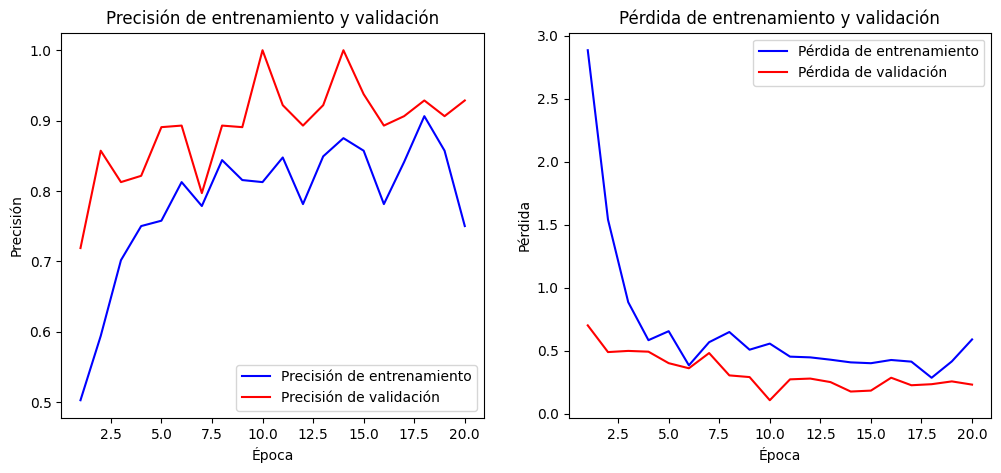

In [8]:
# Evaluar en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Precisión en el conjunto de prueba: {test_accuracy*100:.2f}%')

# Graficar las curvas de entrenamiento
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, min(len(acc), len(val_acc), len(loss), len(val_loss)) + 1)

    plt.figure(figsize=(12, 5))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc[:len(epochs)], 'b-', label='Precisión de entrenamiento')
    plt.plot(epochs, val_acc[:len(epochs)], 'r-', label='Precisión de validación')
    plt.title('Precisión de entrenamiento y validación')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss[:len(epochs)], 'b-', label='Pérdida de entrenamiento')
    plt.plot(epochs, val_loss[:len(epochs)], 'r-', label='Pérdida de validación')
    plt.title('Pérdida de entrenamiento y validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.show()

plot_history(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step


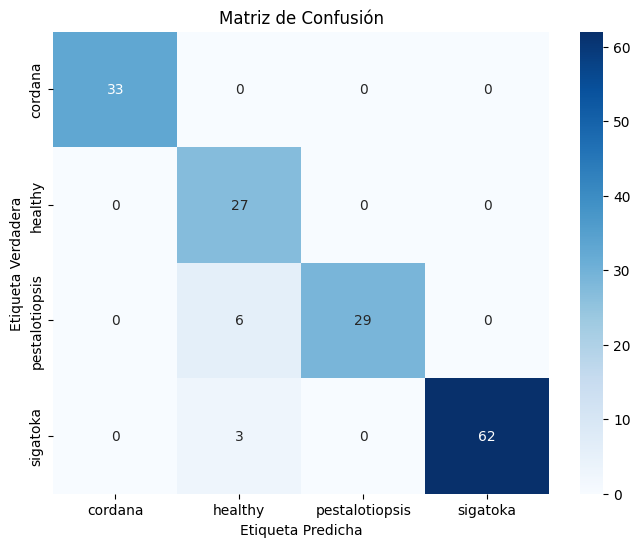

                precision    recall  f1-score   support

       cordana       1.00      1.00      1.00        33
       healthy       0.75      1.00      0.86        27
pestalotiopsis       1.00      0.83      0.91        35
      sigatoka       1.00      0.95      0.98        65

      accuracy                           0.94       160
     macro avg       0.94      0.95      0.93       160
  weighted avg       0.96      0.94      0.95       160



In [9]:
# Obtener las predicciones y etiquetas verdaderas
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes[:len(predicted_classes)]
class_labels = list(test_generator.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()

# Informe de clasificación
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
